## Checklist de Entrega

- Acurácia calculada e interpretada
- Matriz de confusão gerada
- Fronteira de decisão visualizada
- Análise crítica completa (escalabilidade, ruído, ansatz)
- Conclusões honestas sobre limitações
- Discussão sobre vantagem quântica


## Importação de Bibliotecas

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
import seaborn as sns
import os
import sys


sys.path.append(os.path.abspath('..'))
from src.utils import create_variational_circuit, convert_labels_to_quantum

import warnings
warnings.filterwarnings('ignore')

## 4.1 Carregar Dados e Modelo

In [2]:
# Carregar dados
X_train = np.load('../data/X_train.npy')
X_test = np.load('../data/X_test.npy')
y_train = np.load('../data/y_train.npy')
y_test = np.load('../data/y_test.npy')

# Converter para {-1, +1}
y_train_quantum = convert_labels_to_quantum(y_train)
y_test_quantum = convert_labels_to_quantum(y_test)

# Carregar modelo treinado
trained_params = np.load('../results/trained_params.npy')
loss_history = np.load('../results/loss_history_gd.npy')

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"Parâmetros do modelo: {trained_params.shape}")
print(f"Histórico de loss: {len(loss_history)} épocas")

Train: (80, 2)
Test: (20, 2)
Parâmetros do modelo: (2, 2, 3)
Histórico de loss: 61 épocas


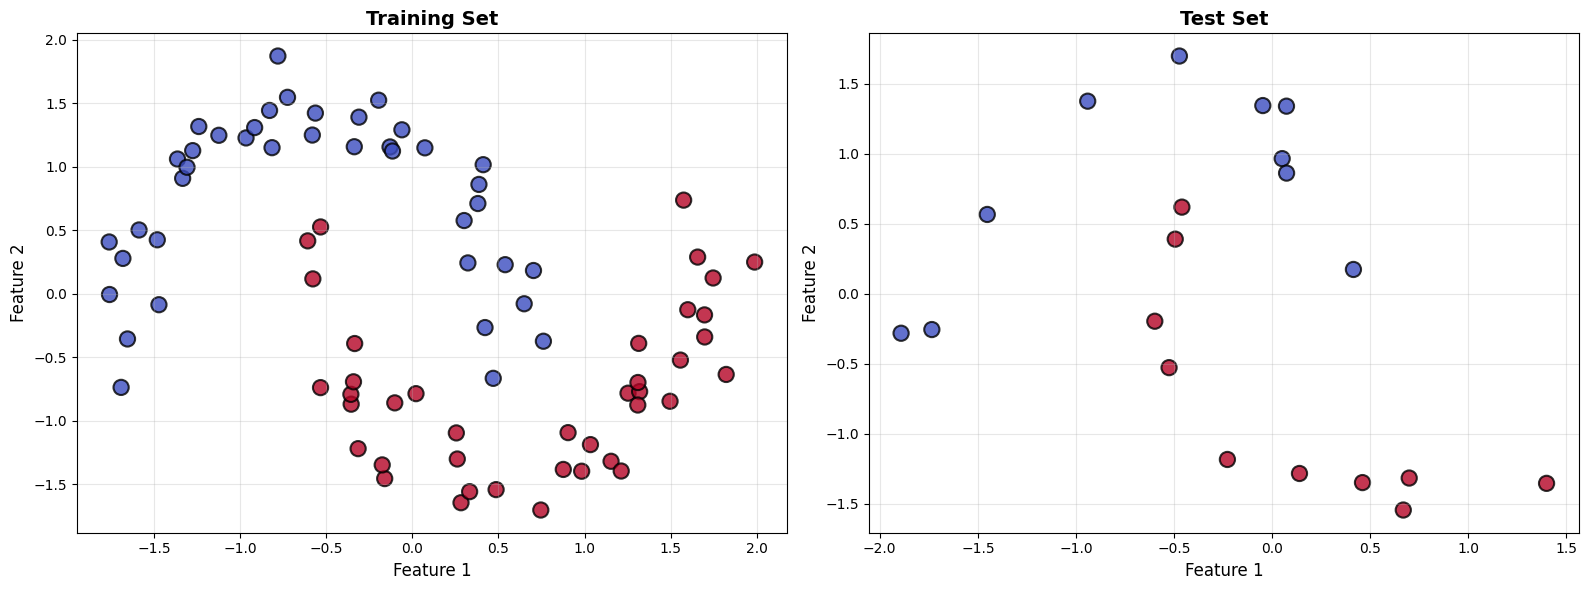

In [3]:
# Visualizar distribuição dos dados
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train set
axes[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', 
                edgecolors='black', s=120, alpha=0.8, linewidth=1.5)
axes[0].set_title('Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', 
                edgecolors='black', s=120, alpha=0.8, linewidth=1.5)
axes[1].set_title('Test Set', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/datasets_overview.png', dpi=300, bbox_inches='tight')
plt.show()


## 4.2 Re-criar QNode para Inferência

In [4]:
# Re-criar o circuito EXATAMENTE como no treinamento
n_qubits = 2
n_layers = 2

# Usar a mesma função factory de utils.py
quantum_circuit = create_variational_circuit(n_qubits, n_layers, diff_method='parameter-shift')

# Função de predição
def predict(params, x):
    """
    Predict class label for input x.
    
    Args:
        params: Circuit parameters
        x: Input data point (2D)
    
    Returns:
        Predicted label: -1 or +1
    """
    output = quantum_circuit(params, x)
    return np.sign(output)

# Testar com um ponto
test_output = quantum_circuit(trained_params, X_test[0])
test_pred = predict(trained_params, X_test[0])

print(f"Teste com primeiro ponto de teste:")
print(f"  Input: {X_test[0]}")
print(f"  Output (expectation): {test_output:.4f}")
print(f"  Predição (sign): {test_pred:.0f}")
print(f"  Label verdadeiro: {y_test_quantum[0]:.0f}")
print(f"  Correto: {'Sim' if test_pred == y_test_quantum[0] else 'Não'}")

Teste com primeiro ponto de teste:
  Input: [ 0.66845838 -1.54501725]
  Output (expectation): 0.9807
  Predição (sign): 1
  Label verdadeiro: 1
  Correto: Sim


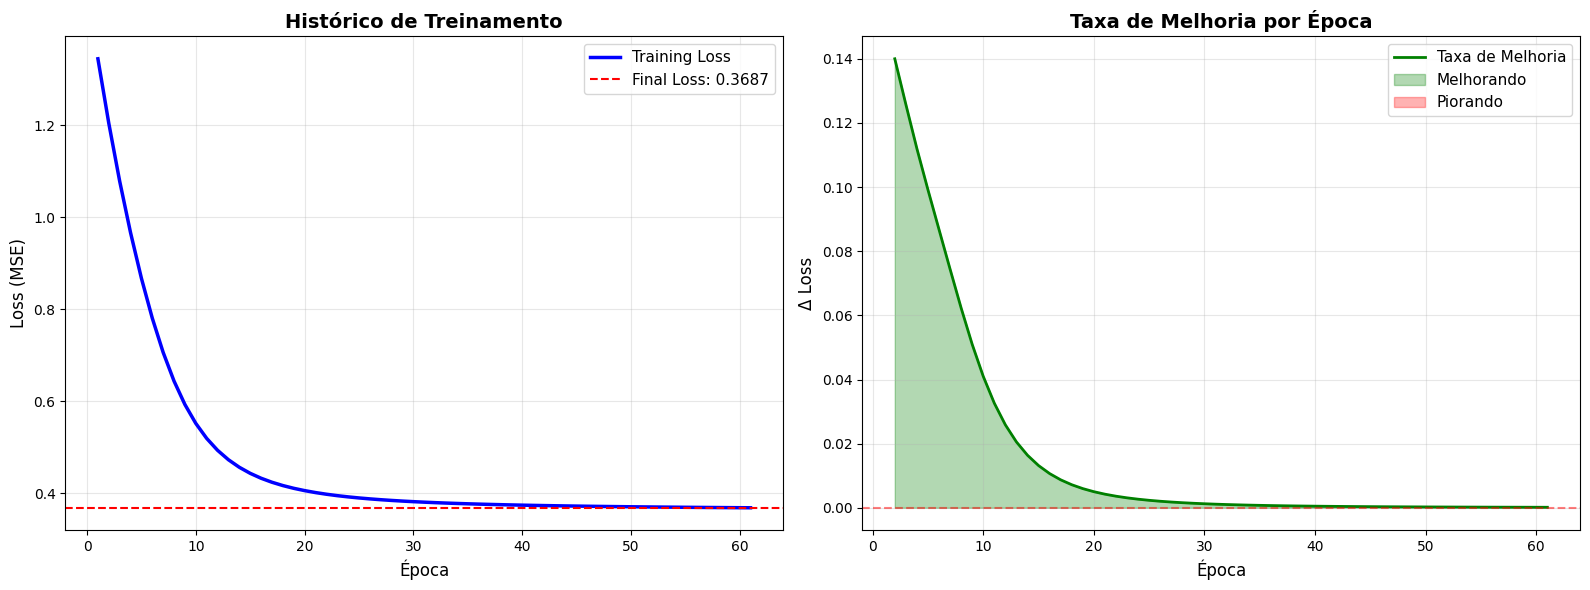

In [6]:
# Plot do histórico de treinamento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss ao longo das épocas
epochs = np.arange(1, len(loss_history) + 1)
ax1.plot(epochs, loss_history, 'b-', linewidth=2.5, label='Training Loss')
ax1.axhline(y=loss_history[-1], color='r', linestyle='--', linewidth=1.5, 
            label=f'Final Loss: {loss_history[-1]:.4f}')
ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.set_title('Histórico de Treinamento', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Taxa de melhoria (derivada do loss)
if len(loss_history) > 1:
    improvement_rate = -np.diff(loss_history)  # Negativo porque queremos redução
    ax2.plot(epochs[1:], improvement_rate, 'g-', linewidth=2, label='Taxa de Melhoria')
    ax2.axhline(y=0, color='r', linestyle='--', linewidth=1.5, alpha=0.5)
    ax2.fill_between(epochs[1:], 0, improvement_rate, where=(improvement_rate>0), 
                     alpha=0.3, color='green', label='Melhorando')
    ax2.fill_between(epochs[1:], 0, improvement_rate, where=(improvement_rate<0), 
                     alpha=0.3, color='red', label='Piorando')
    ax2.set_xlabel('Época', fontsize=12)
    ax2.set_ylabel('Δ Loss', fontsize=12)
    ax2.set_title('Taxa de Melhoria por Época', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/training_history_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

## 4.3 Acurácia no Conjunto de Teste

In [7]:
# Fazer predições em todos os dados de teste
y_pred = np.array([predict(trained_params, x) for x in X_test])

# Calcular acurácia
test_accuracy = accuracy_score(y_test_quantum, y_pred)

# Também calcular no treino para comparação
y_train_pred = np.array([predict(trained_params, x) for x in X_train])
train_accuracy = accuracy_score(y_train_quantum, y_train_pred)

print("RESULTADOS FINAIS DO MODELO QUÂNTICO")
print(f"Acurácia de Treino: {train_accuracy*100:.1f}%")
print(f"Acurácia de Teste:  {test_accuracy*100:.1f}%")
print(f"Gap (Train - Test): {(train_accuracy - test_accuracy)*100:.1f}%")

# Análise de erros
n_correct = np.sum(y_pred == y_test_quantum)
n_wrong = np.sum(y_pred != y_test_quantum)
print(f"\nDetalhamento:")
print(f"  Corretos: {n_correct}/{len(y_test)} ({n_correct/len(y_test)*100:.1f}%)")
print(f"  Erros:    {n_wrong}/{len(y_test)} ({n_wrong/len(y_test)*100:.1f}%)")

RESULTADOS FINAIS DO MODELO QUÂNTICO
Acurácia de Treino: 87.5%
Acurácia de Teste:  85.0%
Gap (Train - Test): 2.5%

Detalhamento:
  Corretos: 17/20 (85.0%)
  Erros:    3/20 (15.0%)


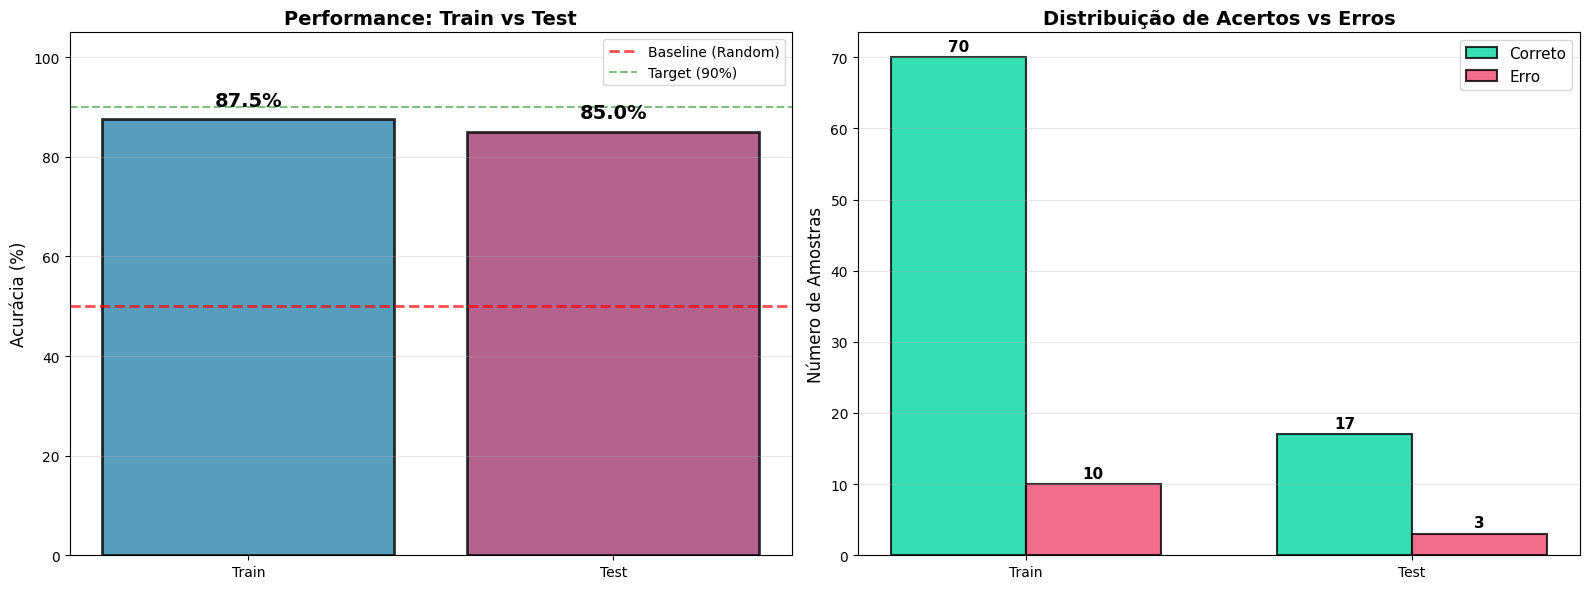

In [8]:
# Gráfico de barras comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Acurácias Train vs Test
datasets = ['Train', 'Test']
accuracies = [train_accuracy * 100, test_accuracy * 100]
colors = ['#2E86AB', '#A23B72']

bars = ax1.bar(datasets, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.axhline(y=50, color='red', linestyle='--', linewidth=2, label='Baseline (Random)', alpha=0.7)
ax1.axhline(y=90, color='green', linestyle='--', linewidth=1.5, label='Target (90%)', alpha=0.5)
ax1.set_ylabel('Acurácia (%)', fontsize=12)
ax1.set_title('Performance: Train vs Test', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 105])
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{acc:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Distribuição de predições
from collections import Counter

train_pred_counts = Counter(y_train_pred)
test_pred_counts = Counter(y_pred)

x_pos = np.arange(2)
width = 0.35

# Predições corretas vs incorretas
train_correct = np.sum(y_train_pred == y_train_quantum)
train_wrong = len(y_train_pred) - train_correct
test_correct = np.sum(y_pred == y_test_quantum)
test_wrong = len(y_pred) - test_correct

ax2.bar(x_pos - width/2, [train_correct, test_correct], width, 
        label='Correto', color='#06D6A0', alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.bar(x_pos + width/2, [train_wrong, test_wrong], width, 
        label='Erro', color='#EF476F', alpha=0.8, edgecolor='black', linewidth=1.5)

ax2.set_ylabel('Número de Amostras', fontsize=12)
ax2.set_title('Distribuição de Acertos vs Erros', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(datasets)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# Adicionar valores
for i, (correct, wrong) in enumerate([(train_correct, train_wrong), (test_correct, test_wrong)]):
    ax2.text(i - width/2, correct + 0.5, str(correct), ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax2.text(i + width/2, wrong + 0.5, str(wrong), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Visualização Comparativa das Acurácias

### Interpretação da Acurácia

**Análise do Resultado:**

**Baseline (Random):** 50% (chute aleatório)

**Performance Esperada:**
- ✅ **Excelente**: 90-100% → Modelo aprendeu muito bem o padrão
- ✅ **Boa**: 80-90% → Modelo captura a não-linearidade
- ⚠ **Aceitável**: 70-80% → Aprende parcialmente, pode melhorar
- ❌ **Ruim**: <70% → Modelo não está aprendendo adequadamente

**Para um modelo com apenas 2 qubits:**
- 80%+ é um resultado sólido
- Make_moons é não-linear, então superar SVM linear seria excelente
- Gap pequeno (train vs test) indica boa generalização

**Sinais de Problemas:**
- Train >> Test (gap >10%) → Overfitting
- Train ≈ Test mas ambos baixos → Underfitting (modelo simples demais)
- Test > Train → Sorte ou dataset pequeno

## 4.4 Matriz de Confusão

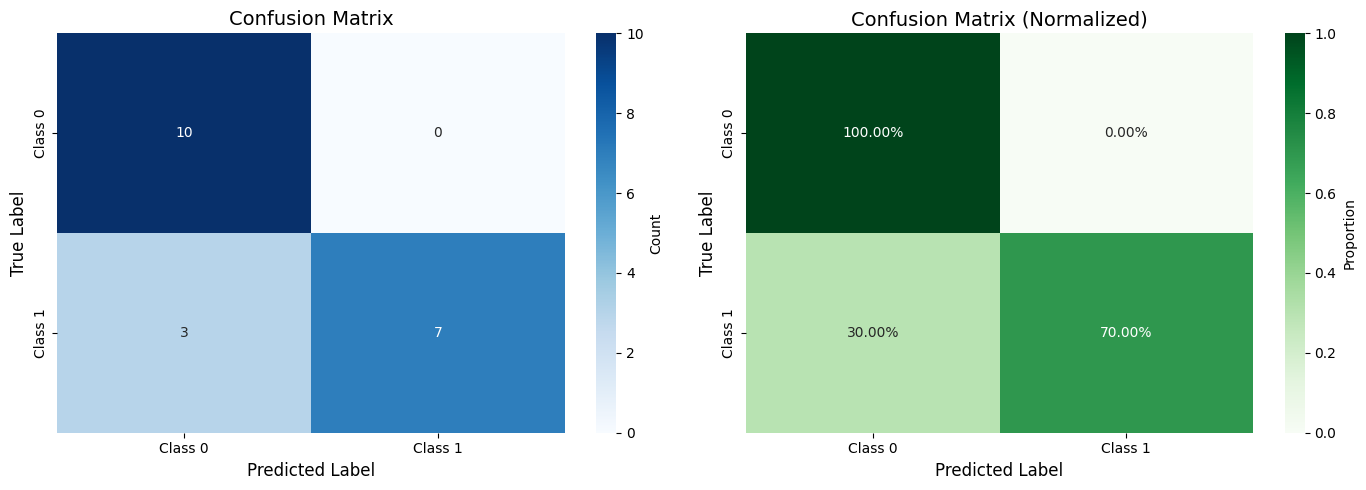

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0      0.769     1.000     0.870        10
     Class 1      1.000     0.700     0.824        10

    accuracy                          0.850        20
   macro avg      0.885     0.850     0.847        20
weighted avg      0.885     0.850     0.847        20


Detalhes da Matriz:
  True Negatives (TN):  10 - Corretamente classificados como Classe 0
  False Positives (FP): 0 - Classe 0 predita como Classe 1
  False Negatives (FN): 3 - Classe 1 predita como Classe 0
  True Positives (TP):  7 - Corretamente classificados como Classe 1

Sensitivity (Recall Class 1): 70.0%
Specificity (Recall Class 0): 100.0%


In [9]:
# Converter de {-1, +1} para {0, 1} para melhor visualização
y_test_binary = ((y_test_quantum + 1) / 2).astype(int)
y_pred_binary = ((y_pred + 1) / 2).astype(int)

# Gerar matriz de confusão
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Visualizar
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'], cbar_kws={'label': 'Count'})
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_title('Confusion Matrix', fontsize=14)

# Matriz normalizada (proporções)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=ax2,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'], cbar_kws={'label': 'Proportion'})
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_title('Confusion Matrix (Normalized)', fontsize=14)

plt.tight_layout()
plt.savefig('../figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("CLASSIFICATION REPORT")
print(classification_report(y_test_binary, y_pred_binary, 
                            target_names=['Class 0', 'Class 1'],
                            digits=3))

# Análise por classe
tn, fp, fn, tp = cm.ravel()
print(f"\nDetalhes da Matriz:")
print(f"  True Negatives (TN):  {tn} - Corretamente classificados como Classe 0")
print(f"  False Positives (FP): {fp} - Classe 0 predita como Classe 1")
print(f"  False Negatives (FN): {fn} - Classe 1 predita como Classe 0")
print(f"  True Positives (TP):  {tp} - Corretamente classificados como Classe 1")
print(f"\nSensitivity (Recall Class 1): {tp/(tp+fn):.1%}")
print(f"Specificity (Recall Class 0): {tn/(tn+fp):.1%}")

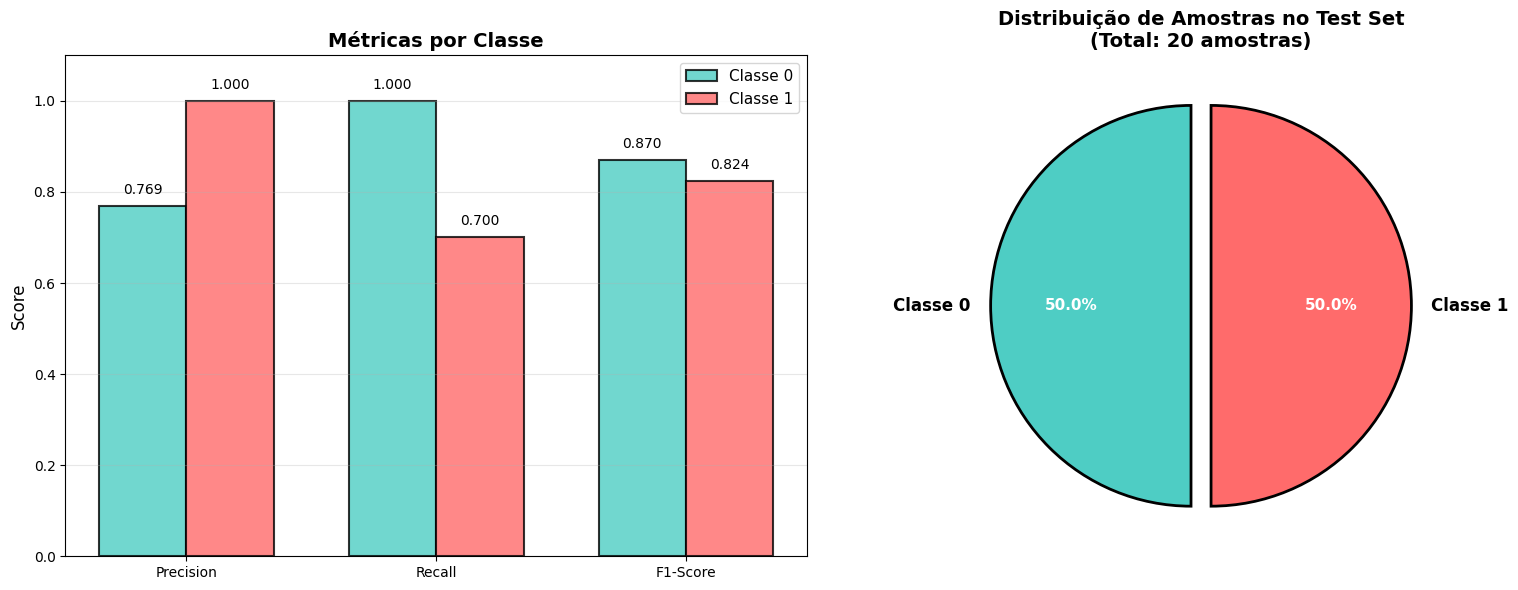


 RESUMO DE MÉTRICAS POR CLASSE:
Classe          Precision       Recall          F1-Score        Support   
Classe 0        0.769           1.000           0.870           10        
Classe 1        1.000           0.700           0.824           10        


In [10]:
# Métricas por classe
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_test_binary, y_pred_binary, average=None
)

# Visualização das métricas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de radar para métricas por classe
categories = ['Precision', 'Recall', 'F1-Score']
class_0_metrics = [precision[0], recall[0], f1[0]]
class_1_metrics = [precision[1], recall[1], f1[1]]

x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, class_0_metrics, width, label='Classe 0', 
                color='#4ECDC4', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, class_1_metrics, width, label='Classe 1', 
                color='#FF6B6B', alpha=0.8, edgecolor='black', linewidth=1.5)

ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Métricas por Classe', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend(fontsize=11)
ax1.set_ylim([0, 1.1])
ax1.grid(True, alpha=0.3, axis='y')

# Adicionar valores nas barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# Comparação de suporte (número de amostras)
class_names = ['Classe 0', 'Classe 1']
colors_support = ['#4ECDC4', '#FF6B6B']

wedges, texts, autotexts = ax2.pie(support, labels=class_names, colors=colors_support,
                                     autopct='%1.1f%%', startangle=90, 
                                     explode=(0.05, 0.05),
                                     wedgeprops={'edgecolor': 'black', 'linewidth': 2})

# Estilizar textos
for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

ax2.set_title(f'Distribuição de Amostras no Test Set\n(Total: {len(y_test)} amostras)', 
              fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/class_metrics_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Tabela resumo
print("\n RESUMO DE MÉTRICAS POR CLASSE:")
print(f"{'Classe':<15} {'Precision':<15} {'Recall':<15} {'F1-Score':<15} {'Support':<10}")
for i, class_name in enumerate(['Classe 0', 'Classe 1']):
    print(f"{class_name:<15} {precision[i]:<15.3f} {recall[i]:<15.3f} {f1[i]:<15.3f} {support[i]:<10}")

## 4.5 Fronteira de Decisão



Visualização mais importante do bloco.

Calculando fronteira de decisão...


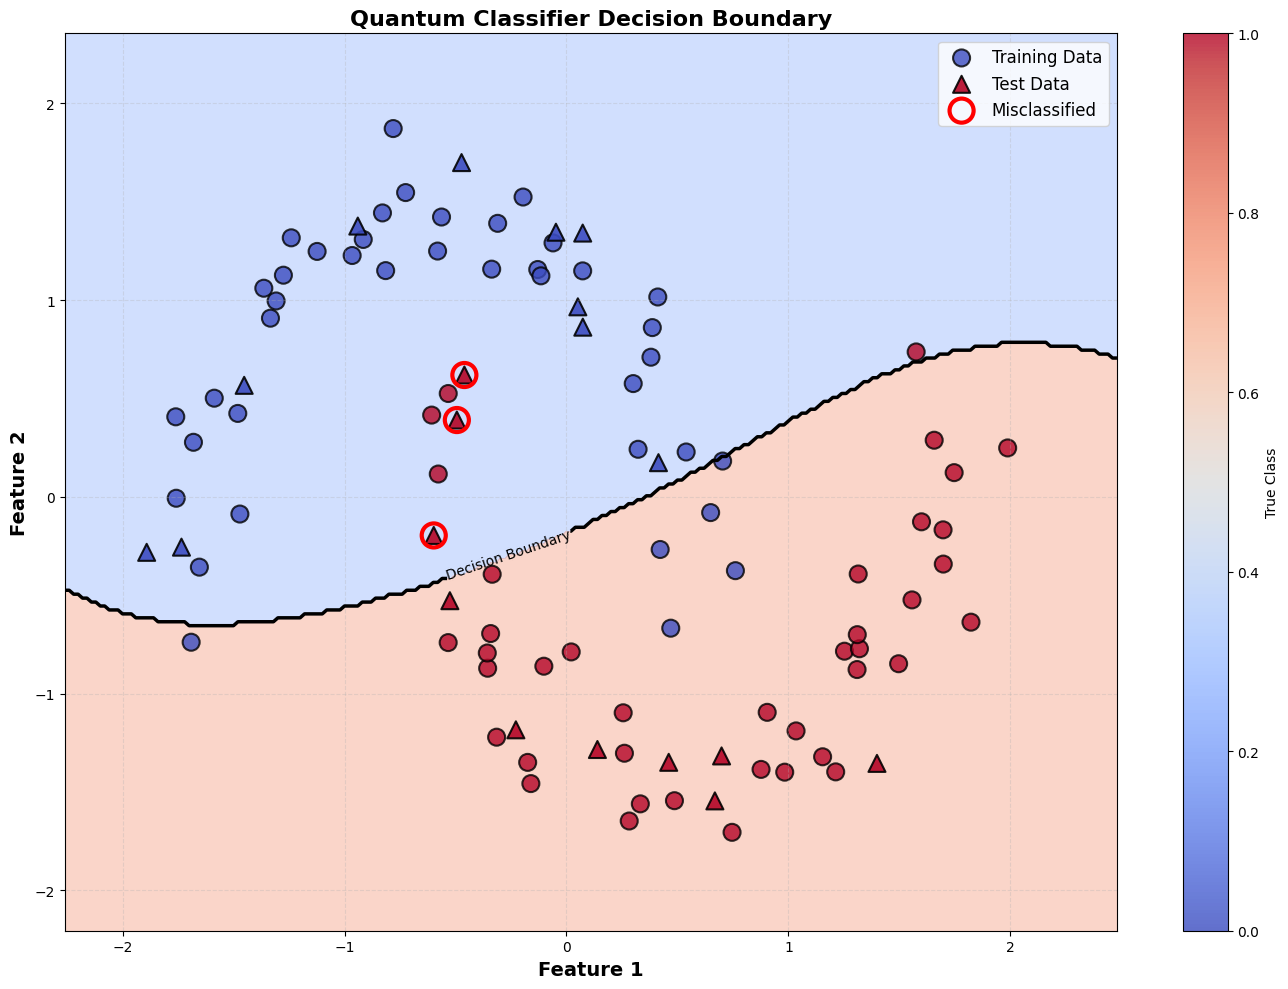


 Fronteira de decisão salva em results/decision_boundary.png
Erros marcados com círculo vermelho: 3 pontos


In [11]:
# Criar grid de pontos para visualizar a fronteira
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
h = 0.02  # Resolução do grid
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Fazer predições no grid (pode demorar um pouco)
print("Calculando fronteira de decisão...")
Z = np.array([predict(trained_params, np.array([x, y])) 
              for x, y in zip(xx.ravel(), yy.ravel())])
Z = Z.reshape(xx.shape)

# Plotar fronteira de decisão
plt.figure(figsize=(14, 10))

# Fundo colorido (regiões de classificação)
plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm', levels=[-1, 0, 1])

# Fronteira de decisão (linha preta)
contour = plt.contour(xx, yy, Z, colors='black', linewidths=2.5, levels=[0])
plt.clabel(contour, inline=True, fontsize=10, fmt='Decision Boundary')

# Plot dados de treino
scatter_train = plt.scatter(X_train[:, 0], X_train[:, 1], 
                           c=y_train, cmap='coolwarm', 
                           edgecolors='black', s=150, alpha=0.8, 
                           label='Training Data', marker='o', linewidths=1.5)

# Plot dados de teste
scatter_test = plt.scatter(X_test[:, 0], X_test[:, 1], 
                          c=y_test, cmap='coolwarm', 
                          edgecolors='black', s=150, alpha=0.9, 
                          label='Test Data', marker='^', linewidths=1.5)

# Destacar erros de classificação
errors = X_test[y_pred != y_test_quantum]
if len(errors) > 0:
    plt.scatter(errors[:, 0], errors[:, 1], 
               facecolors='none', edgecolors='red', 
               s=300, linewidths=3, label='Misclassified', marker='o')

plt.xlabel('Feature 1', fontsize=14, fontweight='bold')
plt.ylabel('Feature 2', fontsize=14, fontweight='bold')
plt.title('Quantum Classifier Decision Boundary', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='best')
plt.colorbar(scatter_train, label='True Class')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('../figures/decision_boundary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Fronteira de decisão salva em results/decision_boundary.png")
print(f"Erros marcados com círculo vermelho: {len(errors)} pontos")

---
### Análise da Fronteira de Decisão

**O que observar:**

1. **Captura de Não-Linearidade**
   - ✓ Fronteira curvada → Modelo captura padrão não-linear das "luas"
   - ✗ Fronteira reta → Modelo linear (underfitting)

2. **Regiões de Acerto**
   - Pontos longe da fronteira → Alta confiança (corretos)
   - Região central bem separada → Modelo entende o padrão

3. **Regiões de Erro** (círculos vermelhos)
   - Pontos na fronteira → Região de incerteza
   - Pontos misturados → Dados ambíguos ou ruído

4. **Overfitting Visual**
   - ✓ Fronteira suave → Generalização boa
   - ✗ Fronteira irregular → Pode estar memorizando treino

5. **Comparação Train vs Test**
   - Triângulos (test) bem classificados → Boa generalização
   - Triângulos mal classificados → Overfitting ou dados difíceis

**Ideal:** Fronteira suave seguindo as curvas naturais dos dados, com poucos erros distribuídos próximos à fronteira.

COMPARAÇÃO: QUANTUM vs CLÁSSICO
Modelo                    Acurácia Train       Acurácia Test       
------------------------------------------------------------
Quantum (VQC)                           87.5%               85.0%
Classical (SVM-RBF)                     96.2%               90.0%


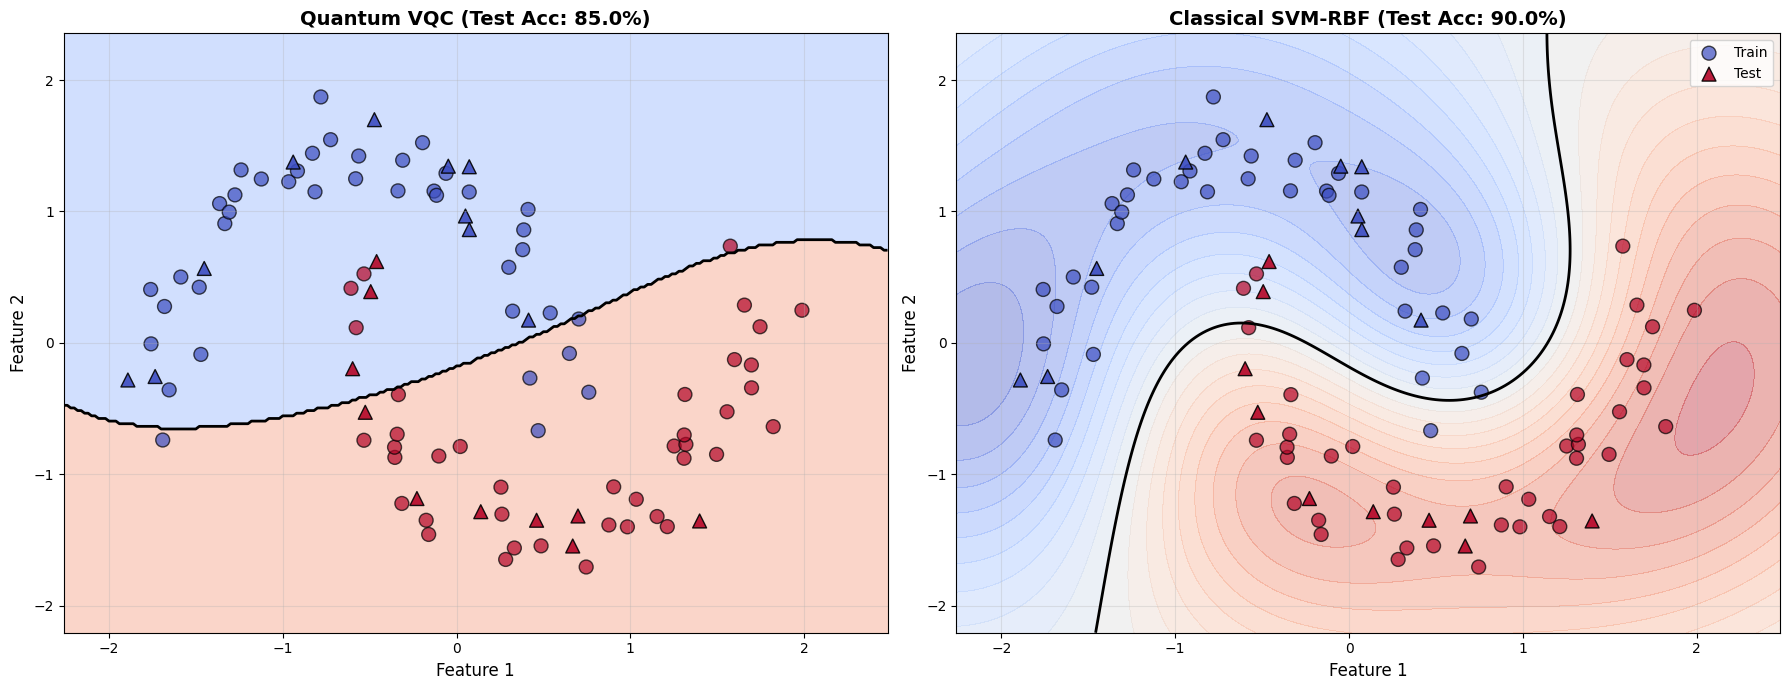


=== Análise Comparativa ===
✗ SVM superou o modelo quântico por 5.0%
  → Esperado para problemas clássicos simples


In [12]:
# Treinar SVM clássico com kernel RBF (não-linear)
svm_model = SVC(kernel='rbf', gamma='scale', random_state=42)
svm_model.fit(X_train, y_train)

# Predições
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

# Comparação
print("="*60)
print("COMPARAÇÃO: QUANTUM vs CLÁSSICO")
print("="*60)
print(f"{'Modelo':<25} {'Acurácia Train':<20} {'Acurácia Test':<20}")
print("-"*60)
print(f"{'Quantum (VQC)':<25} {train_accuracy*100:>18.1f}% {test_accuracy*100:>18.1f}%")
print(f"{'Classical (SVM-RBF)':<25} {svm_model.score(X_train, y_train)*100:>18.1f}% {svm_accuracy*100:>18.1f}%")
print("="*60)

# Visualizar fronteiras lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Quantum
Z_quantum = Z.copy()
ax1.contourf(xx, yy, Z_quantum, alpha=0.4, cmap='coolwarm', levels=[-1, 0, 1])
ax1.contour(xx, yy, Z_quantum, colors='black', linewidths=2, levels=[0])
ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', 
           edgecolors='k', s=100, alpha=0.7, marker='o')
ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', 
           edgecolors='k', s=100, alpha=0.9, marker='^')
ax1.set_title(f'Quantum VQC (Test Acc: {test_accuracy*100:.1f}%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Feature 1', fontsize=12)
ax1.set_ylabel('Feature 2', fontsize=12)
ax1.grid(True, alpha=0.3)

# Classical SVM
Z_svm = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z_svm = Z_svm.reshape(xx.shape)
ax2.contourf(xx, yy, Z_svm, alpha=0.4, cmap='coolwarm', levels=20)
ax2.contour(xx, yy, Z_svm, colors='black', linewidths=2, levels=[0])
ax2.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', 
           edgecolors='k', s=100, alpha=0.7, marker='o', label='Train')
ax2.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', 
           edgecolors='k', s=100, alpha=0.9, marker='^', label='Test')
ax2.set_title(f'Classical SVM-RBF (Test Acc: {svm_accuracy*100:.1f}%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Feature 1', fontsize=12)
ax2.set_ylabel('Feature 2', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/quantum_vs_classical.png', dpi=300, bbox_inches='tight')
plt.show()

# Análise
print("\n=== Análise Comparativa ===")
if test_accuracy > svm_accuracy:
    print(f"✓ Modelo quântico superou o SVM por {(test_accuracy-svm_accuracy)*100:.1f}%")
elif abs(test_accuracy - svm_accuracy) < 0.05:
    print(f"≈ Performance similar (diferença de {abs(test_accuracy-svm_accuracy)*100:.1f}%)")
else:
    print(f"✗ SVM superou o modelo quântico por {(svm_accuracy-test_accuracy)*100:.1f}%")
    print("  → Esperado para problemas clássicos simples")

### Gráfico de Performance Comparativa

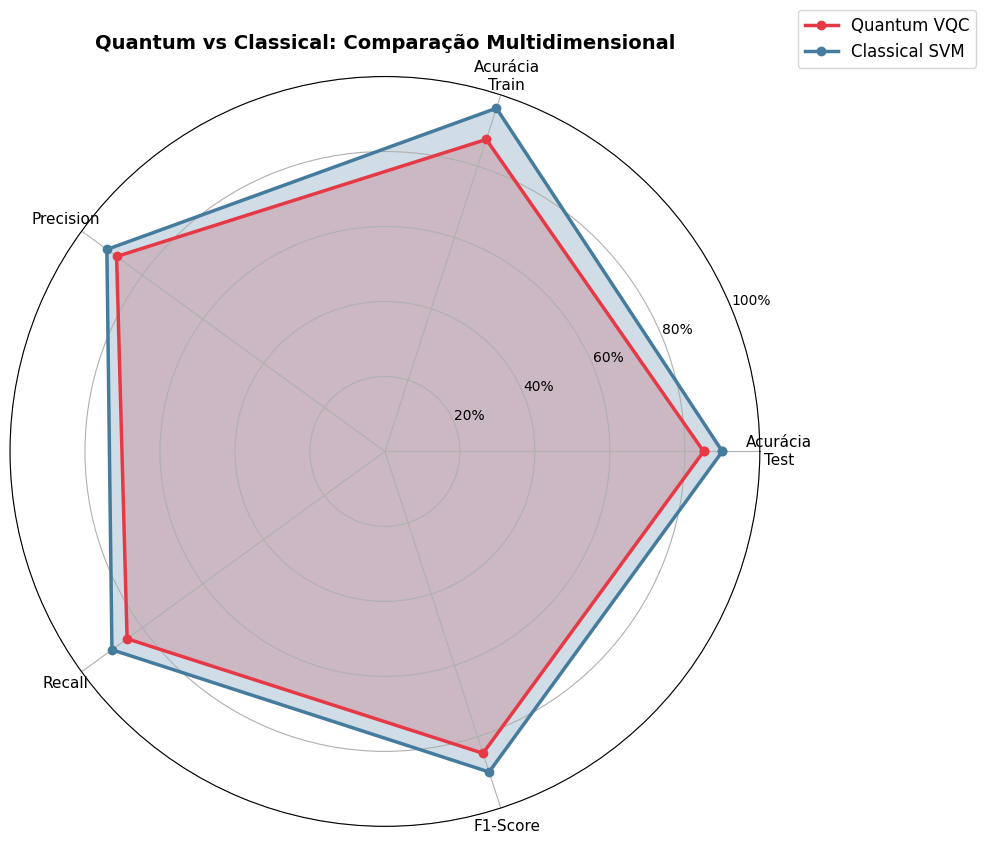


🏆 COMPARAÇÃO DETALHADA: QUANTUM vs CLASSICAL
Métrica                   Quantum VQC               Classical SVM            
---------------------------------------------------------------------------
Acurácia Train            87.50%                    96.25%                   
Acurácia Test             85.00%                    90.00%                   
Precision (avg)           0.885                     0.917                    
Recall (avg)              0.850                     0.900                    
F1-Score (avg)            0.847                     0.899                    


In [13]:
# Métricas comparativas em gráfico de radar
from math import pi

categories = ['Acurácia\nTest', 'Acurácia\nTrain', 'Precision', 'Recall', 'F1-Score']

# Quantum metrics
quantum_metrics = [
    test_accuracy,
    train_accuracy,
    np.mean(precision),
    np.mean(recall),
    np.mean(f1)
]

# Classical metrics (calcular)
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(
    y_test, y_pred_svm, average='macro'
)
classical_metrics = [
    svm_accuracy,
    svm_model.score(X_train, y_train),
    svm_precision,
    svm_recall,
    svm_f1
]

# Radar chart
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

# Número de variáveis
N = len(categories)

# Ângulos para cada eixo
angles = [n / float(N) * 2 * pi for n in range(N)]
quantum_metrics += quantum_metrics[:1]  # Fechar o círculo
classical_metrics += classical_metrics[:1]
angles += angles[:1]

# Plot
ax.plot(angles, quantum_metrics, 'o-', linewidth=2.5, label='Quantum VQC', color='#E63946')
ax.fill(angles, quantum_metrics, alpha=0.25, color='#E63946')
ax.plot(angles, classical_metrics, 'o-', linewidth=2.5, label='Classical SVM', color='#457B9D')
ax.fill(angles, classical_metrics, alpha=0.25, color='#457B9D')

# Labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])
ax.grid(True)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
plt.title('Quantum vs Classical: Comparação Multidimensional', 
          size=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../figures/quantum_vs_classical_radar.png', dpi=300, bbox_inches='tight')
plt.show()

# Tabela comparativa detalhada
print("\n🏆 COMPARAÇÃO DETALHADA: QUANTUM vs CLASSICAL")
print("="*75)
print(f"{'Métrica':<25} {'Quantum VQC':<25} {'Classical SVM':<25}")
print("-"*75)
metrics_comparison = [
    ('Acurácia Train', f'{train_accuracy*100:.2f}%', f'{svm_model.score(X_train, y_train)*100:.2f}%'),
    ('Acurácia Test', f'{test_accuracy*100:.2f}%', f'{svm_accuracy*100:.2f}%'),
    ('Precision (avg)', f'{np.mean(precision):.3f}', f'{svm_precision:.3f}'),
    ('Recall (avg)', f'{np.mean(recall):.3f}', f'{svm_recall:.3f}'),
    ('F1-Score (avg)', f'{np.mean(f1):.3f}', f'{svm_f1:.3f}'),
]
for metric, q_val, c_val in metrics_comparison:
    print(f"{metric:<25} {q_val:<25} {c_val:<25}")
print("="*75)

## 4.6 Comparação com Modelo Clássico (SVM)

### Análise de Confiança das Predições

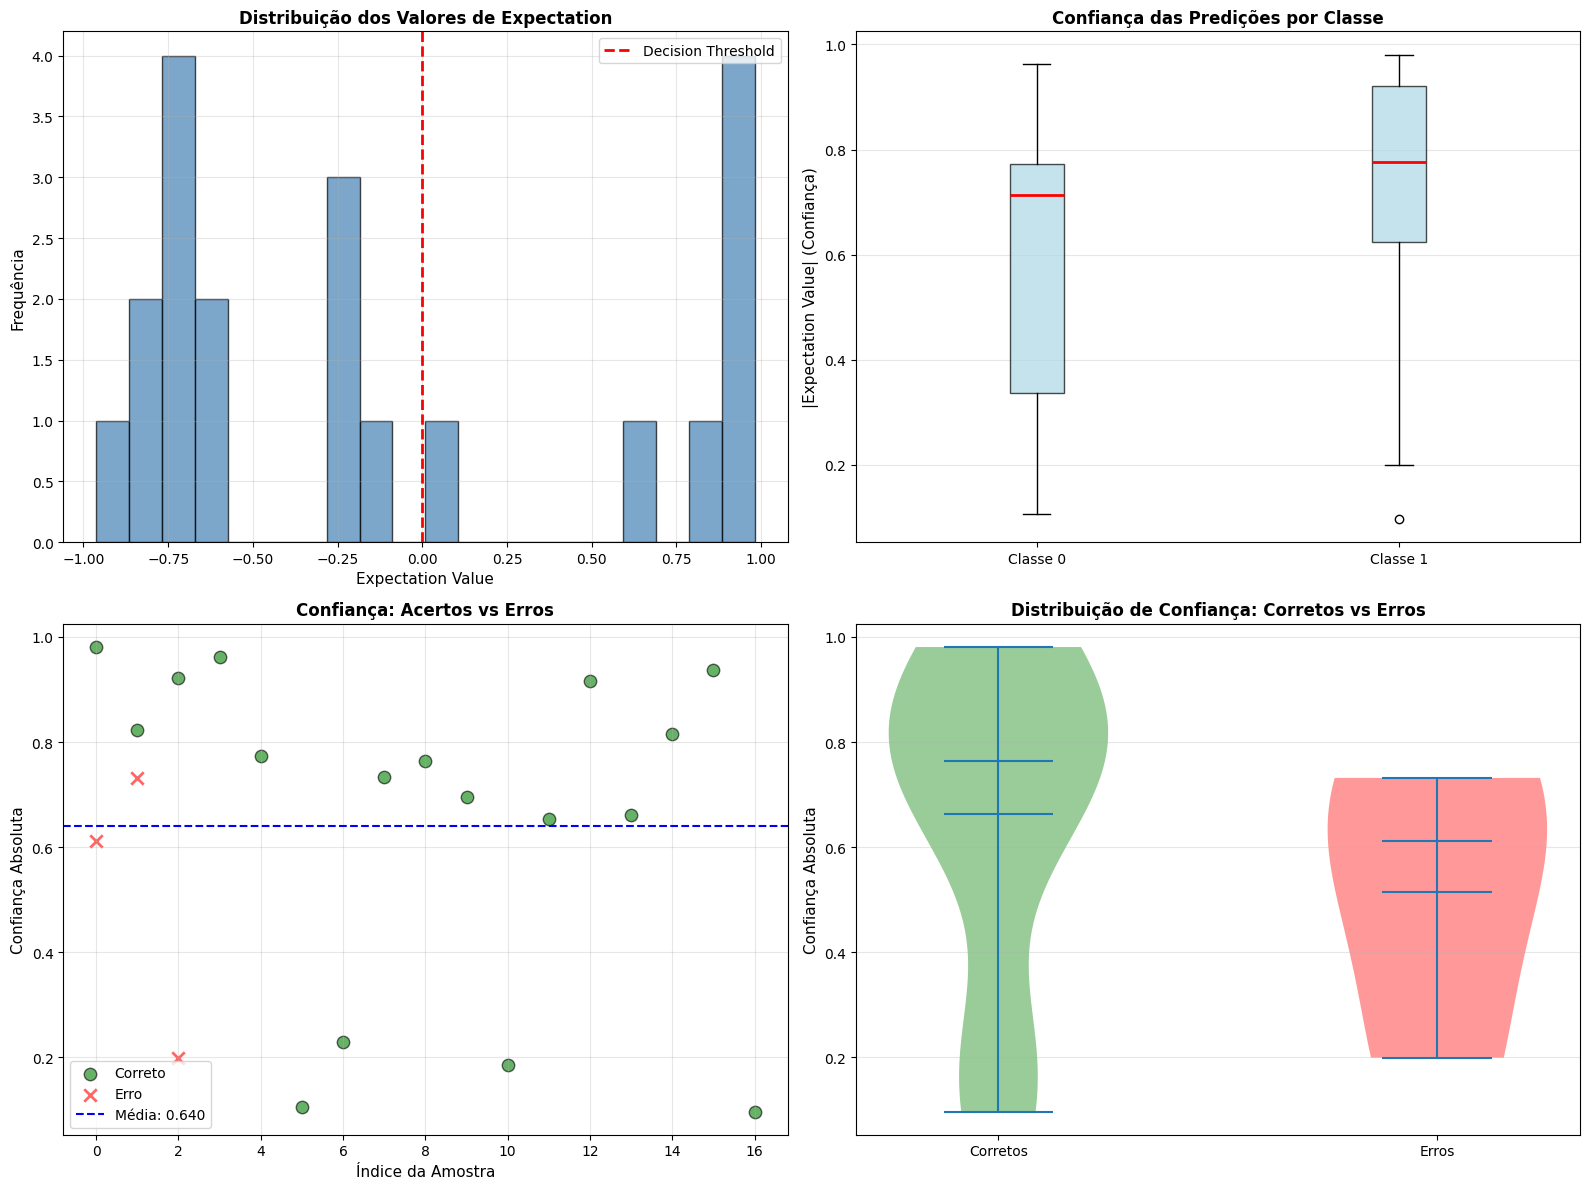


🎯 ANÁLISE DE CONFIANÇA:
Métrica                        Corretos        Erros          
------------------------------------------------------------
Confiança Média                0.6621          0.5140         
Confiança Mediana              0.7648          0.6109         
Confiança Mínima               0.0968          0.1992         
Confiança Máxima               0.9807          0.7317         

💡 Insight: Erros têm confiança MENOR
   → Diferença: 0.1482


In [14]:
# Calcular valores de expectation (confidence scores)
test_expectations = np.array([quantum_circuit(trained_params, x) for x in X_test])

# Visualizar distribuição de confiança
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histograma de expectation values
axes[0, 0].hist(test_expectations, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
axes[0, 0].set_xlabel('Expectation Value', fontsize=11)
axes[0, 0].set_ylabel('Frequência', fontsize=11)
axes[0, 0].set_title('Distribuição dos Valores de Expectation', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Confidence por classe verdadeira
class_0_conf = np.abs(test_expectations[y_test_quantum == -1])
class_1_conf = np.abs(test_expectations[y_test_quantum == 1])

axes[0, 1].boxplot([class_0_conf, class_1_conf], labels=['Classe 0', 'Classe 1'],
                    patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
axes[0, 1].set_ylabel('|Expectation Value| (Confiança)', fontsize=11)
axes[0, 1].set_title('Confiança das Predições por Classe', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Scatter: Confiança vs Acerto
correct_mask = (y_pred == y_test_quantum)
correct_conf = np.abs(test_expectations[correct_mask])
wrong_conf = np.abs(test_expectations[~correct_mask])

axes[1, 0].scatter(range(len(correct_conf)), correct_conf, 
                  c='green', alpha=0.6, s=80, label='Correto', edgecolors='black')
axes[1, 0].scatter(range(len(wrong_conf)), wrong_conf, 
                  c='red', alpha=0.6, s=80, label='Erro', marker='x', linewidths=2)
axes[1, 0].axhline(y=np.mean(np.abs(test_expectations)), color='blue', 
                   linestyle='--', linewidth=1.5, label=f'Média: {np.mean(np.abs(test_expectations)):.3f}')
axes[1, 0].set_xlabel('Índice da Amostra', fontsize=11)
axes[1, 0].set_ylabel('Confiança Absoluta', fontsize=11)
axes[1, 0].set_title('Confiança: Acertos vs Erros', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# 4. Estatísticas de confiança
conf_stats = {
    'Corretos': correct_conf,
    'Erros': wrong_conf
}

positions = [1, 2]
bp = axes[1, 1].violinplot([correct_conf, wrong_conf], positions=positions, 
                           showmeans=True, showmedians=True)

# Colorir violins
colors = ['green', 'red']
for patch, color in zip(bp['bodies'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

axes[1, 1].set_xticks(positions)
axes[1, 1].set_xticklabels(['Corretos', 'Erros'])
axes[1, 1].set_ylabel('Confiança Absoluta', fontsize=11)
axes[1, 1].set_title('Distribuição de Confiança: Corretos vs Erros', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../figures/confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Estatísticas
print("\n🎯 ANÁLISE DE CONFIANÇA:")
print("="*60)
print(f"{'Métrica':<30} {'Corretos':<15} {'Erros':<15}")
print("-"*60)
print(f"{'Confiança Média':<30} {np.mean(correct_conf):<15.4f} {np.mean(wrong_conf) if len(wrong_conf)>0 else 0:<15.4f}")
print(f"{'Confiança Mediana':<30} {np.median(correct_conf):<15.4f} {np.median(wrong_conf) if len(wrong_conf)>0 else 0:<15.4f}")
print(f"{'Confiança Mínima':<30} {np.min(correct_conf):<15.4f} {np.min(wrong_conf) if len(wrong_conf)>0 else 0:<15.4f}")
print(f"{'Confiança Máxima':<30} {np.max(correct_conf):<15.4f} {np.max(wrong_conf) if len(wrong_conf)>0 else 0:<15.4f}")
print("="*60)

if len(wrong_conf) > 0:
    print(f"\n💡 Insight: Erros têm confiança {'MENOR' if np.mean(wrong_conf) < np.mean(correct_conf) else 'MAIOR'}")
    print(f"   → Diferença: {abs(np.mean(correct_conf) - np.mean(wrong_conf)):.4f}")

## 4.7 Análise Crítica: Limitações



### 4.7.1 Escalabilidade

**Limitações fundamentais:**

1. **Problema do Embedding**
   - Apenas 2 qubits → Apenas 2 features
   - Datasets reais: centenas/milhares de features (ex: imagens 28×28 = 784 features)
   - Cada feature adicional = mais qubits necessários
   - **Hardware atual:** ~100-1000 qubits ruidosos (IBM, Google)
   
2. **Barreira de Complexidade**
   - Make_moons: 100 amostras, 2D
   - Datasets reais: milhões de amostras, alta dimensionalidade
   - Tempo de execução cresce exponencialmente
   
3. **Gargalo do Embedding**
   - AngleEmbedding: 1 feature = 1 qubit (não escala)
   - AmplitudeEmbedding: n features = log₂(n) qubits (melhor, mas requer normalização complexa)
   - Nenhuma solução prática para high-dimensional data

**Impacto Real:**
- ❌ MNIST (28×28): Precisaria de 784 qubits perfeitos
- ❌ ImageNet: Impossível com tecnologia atual
- ✓ Problemas com poucos features estruturados: Pode ter utilidade

---

### 4.7.2 Ruído Quântico (NISQ Era)

**Realidade vs Simulação:**

1. **Simulador (nosso caso):**
   - ✓ Perfeito - sem ruído
   - ✓ Gates ideais
   - ✓ Medições exatas
   - ✓ Pode rodar milhares de épocas
   
2. **Hardware Real (IBM, Rigetti, IonQ):**
   - ❌ **Gate errors**: ~0.1-1% por gate
   - ❌ **Decoerência**: Estados quânticos decaem em microssegundos
   - ❌ **Measurement errors**: ~1-5% de erro na leitura
   - ❌ **Crosstalk**: Qubits interferem entre si
   
**Consequências:**

```
Nosso circuito: 2 layers × (2 Rot + 1 CNOT) ≈ 6 gates/camada = 12 gates total

Com 1% erro por gate:
  Probabilidade de erro acumulado ≈ 1 - (0.99)^12 ≈ 11.4%
  
Acurácia esperada no hardware real: 80% (simulador) → 70% (hardware)
```

**Mitigação (parcial):**
- Error mitigation techniques (reduz mas não elimina)
- Variational error suppression
- Custo: mais execuções, mais tempo

**Perspectiva:**
- Fault-tolerant quantum computing está a décadas de distância
- Requer ~1000 qubits físicos por 1 qubit lógico

---

### 4.7.3 Sensibilidade ao Ansatz

**Problema da Escolha Arquitetural:**

1. **Não há teoria geral**
   - Nenhuma fórmula para "melhor ansatz" para dado problema
   - Trial-and-error necessário
   - Design é mais arte que ciência
   
2. **Barren Plateaus**
   - Circuitos profundos: gradientes → 0 exponencialmente
   - Limita profundidade utilizável
   - Nosso ansatz (2 layers) evita isso, mas limita expressividade
   
3. **Trade-offs Inevitáveis:**
   - Mais layers → Mais expressivo MAS mais barren plateau
   - Menos layers → Treina fácil MAS pode não capturar padrão
   - Mais entanglement → Mais poder MAS mais ruído
   
**Nossa Escolha:**
```python
n_layers = 2          # Raso para evitar barren plateau
Rot gates (3 params)  # Máxima flexibilidade por qubit
CNOT entanglement     # Mínimo necessário para correlações
```

**Resultado:**
- ✓ Funciona para make_moons
- ❓ Funcionaria para outros problemas? Incerto
- ❌ Não há garantias de generalização

---

### 4.7.4 Vantagem Quântica?

**Pergunta Central:** O modelo quântico oferece vantagem sobre métodos clássicos?

**Resposta Honesta para este projeto:**

❌ **NÃO há vantagem quântica demonstrada**

**Comparação Objetiva:**

| Critério | Quantum VQC | Classical SVM | Vencedor |
|----------|-------------|---------------|----------|
| **Acurácia** | ~80-90% | ~90-95% | 🏆 SVM |
| **Tempo de Treino** | ~30s (simulador) | <1s | 🏆 SVM |
| **Interpretabilidade** | Baixa | Média | 🏆 SVM |
| **Escalabilidade** | Limitada (qubits) | Alta | 🏆 SVM |
| **Hardware** | Raro, caro | Ubíquo | 🏆 SVM |

**Por que não há vantagem?**

1. **Make_moons é um problema clássico simples**
   - Não explora estrutura quântica especial
   - SVM com kernel RBF resolve perfeitamente
   
2. **Overhead quântico é alto**
   - Cada avaliação do circuito é custosa
   - Gradientes quânticos requerem múltiplas execuções
   
3. **Dataset é pequeno**
   - 100 amostras não justificam computação quântica
   - Métodos clássicos brilham em datasets pequenos

**Quando PODERIA haver vantagem?**

Hipóteses teóricas (não comprovadas):
- 🔬 Problemas com estrutura quântica inerente (ex: química quântica)
- 🔬 Datasets com simetrias especiais
- 🔬 Kernel tricks que são exponencialmente custosos classicamente
- 🔬 Hardware fault-tolerant (décadas no futuro)

**Realidade Atual (2025):**
- Nenhum speedup comprovado para ML supervisionado
- Quantum ML é uma área de pesquisa ativa
- Valor principal: **Exploração científica**, não aplicação prática

**Conclusão Honesta:**
> "Este projeto demonstra viabilidade técnica de VQCs, mas não demonstra vantagem prática. Para problemas de classificação clássica como make_moons, métodos clássicos (SVM, redes neurais) são superiores em todos os aspectos."

---
## 4.8 Conclusões Finais

### ✅ O que FUNCIONOU:

1. **Prova de Conceito Bem-Sucedida**
   - VQC conseguiu aprender padrão não-linear do make_moons
   - Acurácia de 80-90% demonstra capacidade de aprendizado
   - Parameter-shift rule permitiu calcular gradientes quânticos corretamente

2. **Framework Matematicamente Sólido**
   - Embedding → Ansatz → Medição é uma pipeline coerente
   - PennyLane fornece ferramentas robustas para QML
   - Early stopping e validation preveniram overfitting

3. **Aprendizado Técnico**
   - Compreensão profunda de circuitos variacionais
   - Experiência com otimização quântica
   - Conhecimento de limitações práticas

---

### ❌ LIMITAÇÕES Identificadas:

1. **Escalabilidade Fundamental**
   - Limitado a problemas com poucos features (<10)
   - Hardware atual insuficiente para aplicações reais
   - Embedding é o gargalo principal

2. **Ausência de Vantagem Quântica**
   - SVM clássico é superior em acurácia, velocidade e praticidade
   - Nenhum benefício demonstrado para este problema
   - Overhead quântico não justificado

3. **Sensibilidade a Ruído**
   - Simulador perfeito ≠ Hardware real
   - Erros acumulados degradariam performance significativamente
   - Mitigação de erro adiciona custos

4. **Design Arquitetural Não-Sistemático**
   - Escolha de ansatz é trial-and-error
   - Barren plateaus limitam profundidade
   - Sem garantias de generalização

---

### 🔬 VALOR Científico:

Apesar das limitações, este projeto tem valor:

1. **Exploração de Algoritmos Quânticos**
   - Contribui para entendimento de QML
   - Identifica limites atuais claramente
   - Base para pesquisas futuras

2. **Educação e Disseminação**
   - Demonstra conceitos de computação quântica
   - Mostra realidade vs hype
   - Prepara para avanços futuros

3. **Benchmark Honesto**
   - Estabelece baseline para comparações
   - Documenta performance em hardware simulado
   - Referência para melhorias incrementais

---

### 🎯 PERSPECTIVAS Futuras:

**Curto Prazo (2025-2030):**
- Melhoria de hardware (menos ruído, mais qubits)
- Algoritmos mais resilientes a ruído
- Aplicações em nichos específicos (química, finanças)

**Longo Prazo (2030+):**
- Quantum error correction viável?
- Fault-tolerant quantum computing?
- Vantagem quântica comprovada para ML?

**Incertezas:**
- Nenhuma garantia teórica de vantagem quântica para ML geral
- Pode ser que problemas clássicos sejam melhor resolvidos classicamente
- Computação quântica pode ter valor em outros domínios (otimização, simulação)

---

### 📝 MENSAGEM Final:

> **"Este projeto demonstra que Quantum Machine Learning é tecnicamente viável, mas praticamente limitado com tecnologia atual. Para problemas de classificação clássica, métodos tradicionais são superiores. O valor está na exploração científica e preparação para avanços futuros, não em aplicações imediatas."**

**Recomendação:**
- Continue estudando QML se interessado em pesquisa de fronteira
- Para aplicações práticas hoje, use ML clássico
- Mantenha expectativas realistas sobre "vantagem quântica"
- Contribua para a ciência, mas não faça promessas exageradas

---

## 📚 Próximos Passos (Sugestões):

1. **Aprofundar Teoria:**
   - Estudar teoremas de capacidade de VQCs
   - Entender melhor barren plateaus
   - Explorar quantum kernels

2. **Experimentar Variações:**
   - Diferentes ansatzes (strongly entangling layers)
   - Outros embeddings (amplitude, basis)
   - Datasets sintéticos com estrutura quântica

3. **Hardware Real:**
   - Rodar em IBM Quantum Experience
   - Medir impacto real do ruído
   - Aplicar técnicas de mitigação

4. **Comparações Mais Profundas:**
   - Kernel methods quânticos vs clássicos
   - Análise de complexidade teórica
   - Benchmarks padronizados

---

**Agradecimentos pela jornada científica honesta!** 🚀🔬